In [ ]:
import numpy as np
from matplotlib import pyplot as plt

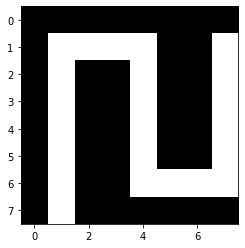

In [ ]:
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 0, 0, 1],
                  [0, 1, 0, 0, 1, 0, 0, 1],
                  [0, 1, 0, 0, 1, 0, 0, 1],
                  [0, 1, 0, 0, 1, 0, 0, 1],
                  [0, 1, 0, 0, 1, 0, 0, 1],
                  [0, 1, 0, 0, 1, 1, 1, 1],
                  [0, 1, 0, 0, 0, 0, 0, 0]])

plt.imshow(image, cmap='gray')

In [ ]:
kernel = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])

def convolution(bin_image, kernel):
    k_size = kernel.shape[0]
    conv = []
    for i in range(bin_image.shape[0] - k_size + 1):
        for j in range(bin_image.shape[1] - k_size + 1):
            section = bin_image[i : i+k_size, j : j+k_size]
            conv.append((section * kernel).sum())
    return np.array(conv).reshape(bin_image.shape[0] - k_size + 1, -1)

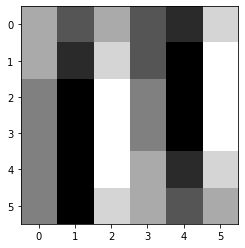

In [ ]:
conv = convolution(image, kernel)
plt.imshow(conv, cmap='gray')

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize, Compose
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5),  # mean по всем 3м каналам
               (0.5, 0.5, 0.5))] # std по всем 3м каналам
)

In [ ]:
training_data = CIFAR10(root="cifar", train=True, download=True, transform=transform)
test_data = CIFAR10(root="cifar", train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [ ]:
batch_size = 4
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}")
    break

Shape of X [N, C, H, W]: torch.Size([4, 3, 32, 32])
Shape of y: torch.Size([4])


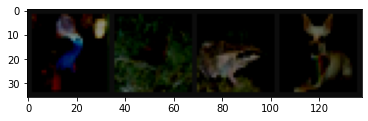

bird  bird  frog  dog  


In [ ]:
def imshow(img):
    img = img / 2 + 0.05 # нормализация для просмотра
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

classes = training_data.classes

dataiter = iter(train_dataloader)
images, labels = next(dataiter)
# make_grid() - создаёт сетку из изображений
imshow(make_grid(images))
print(' '.join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Определение базовой модели

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

model = NeuralNetwork().to(device)
print(model) 

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Функция потерь и оптимизатор

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.001 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # метод, который переводит модель в режим обучения, обеспечивая определённые
    # варианты поведения, которые нам нужны (например, отсев, пакетная норма и т.д.)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 2000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f} [{current:5d}/{size:>5d}]")

# Определение метода тестирования

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # переводим модель в режим тестирования
    model.eval()
    test_loss, correct = 0, 0
    # отключаем вычисление градиента, так как при тестировании 
    # backprop не используется
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

# Обучение модели

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch: {t+1}\n--------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch: 1
--------------------
Loss: 2.330102 [    0/50000]
Loss: 2.022156 [ 8000/50000]
Loss: 1.655453 [16000/50000]
Loss: 1.671349 [24000/50000]
Loss: 1.505009 [32000/50000]
Loss: 1.961665 [40000/50000]
Loss: 2.275244 [48000/50000]
Test Error: 
 Accuracy: 39.8%, Avg loss: 1.716523

Epoch: 2
--------------------
Loss: 1.770401 [    0/50000]
Loss: 1.172554 [ 8000/50000]
Loss: 1.989920 [16000/50000]
Loss: 1.548334 [24000/50000]
Loss: 1.654644 [32000/50000]
Loss: 2.501850 [40000/50000]
Loss: 1.433309 [48000/50000]
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.573339

Epoch: 3
--------------------
Loss: 1.471023 [    0/50000]
Loss: 1.751641 [ 8000/50000]
Loss: 1.008131 [16000/50000]
Loss: 1.373044 [24000/50000]
Loss: 1.744503 [32000/50000]
Loss: 0.873173 [40000/50000]
Loss: 0.756935 [48000/50000]
Test Error: 
 Accuracy: 48.0%, Avg loss: 1.490790

Epoch: 4
--------------------
Loss: 2.128883 [    0/50000]
Loss: 1.593740 [ 8000/50000]
Loss: 2.422871 [16000/50000]
Loss: 1.245415 [24000/50000]
Lo

# Сохранение и загрузка модели

In [ ]:
torch.save(model.state_dict(), "cifar_fc.pth")

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("cifar_fc.pth"))

<All keys matched successfully>

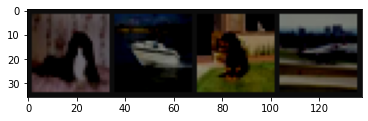

Ground Truth:  dog   ship  dog   airplane


In [ ]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(make_grid(images))
print("Ground Truth: ", " ".join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  frog  ship  dog   airplane


In [ ]:
correct, total = 0, 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Model accuracy: {100 * correct // total} %')

Model accuracy: 54 %


## Проверка классификации каждого класса

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0  for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

{'airplane': 0, 'automobile': 0, 'bird': 0, 'cat': 0, 'deer': 0, 'dog': 0, 'frog': 0, 'horse': 0, 'ship': 0, 'truck': 0}
Accuracy for class airplane: 58.6%
Accuracy for class automobile: 61.6%
Accuracy for class bird : 39.4%
Accuracy for class cat  : 30.3%
Accuracy for class deer : 47.3%
Accuracy for class dog  : 45.8%
Accuracy for class frog : 64.4%
Accuracy for class horse: 65.8%
Accuracy for class ship : 74.6%
Accuracy for class truck: 55.5%
